In [3]:
from make_ewma_features_df import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# Fitting model

In [4]:
gw_df = get_dfs(25)
ewma_merge_lag = make_ewma_features_df(gw_df, 25, 0.4).dropna()

In [5]:
model_dict = {}
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    ewma_merge_lag_pos = ewma_merge_lag.query('position==@pos').set_index(['full_name', 'gw'])
    X = ewma_merge_lag_pos[[
        'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
        'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
        'minutes', 'ewma_total_points', 'ewma_team_goals',
        'ewma_nw_opponent_goals']]

    y = ewma_merge_lag_pos['nw_total_points']

    model = LinearRegression()
    model.fit(X, y)

    model_dict[pos] = model

# Testing on last season

In [6]:
pred_dfs = []
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    gw5_pos = ewma_merge_lag.query('gw==5 and position==@pos').set_index(['full_name', 'gw'])

    pos_pred = model_dict[pos].predict(gw5_pos[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
        'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
        'minutes', 'ewma_total_points', 'ewma_team_goals',
        'ewma_nw_opponent_goals']])

    gw5_pos['pred'] = pos_pred
    pred_dfs.append(gw5_pos)
    
pred_df = pd.concat(pred_dfs)


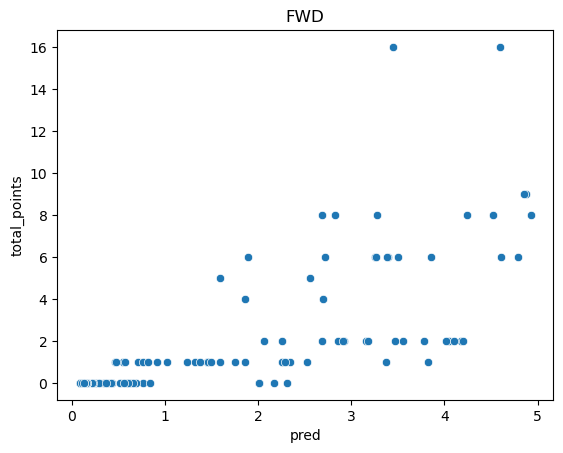

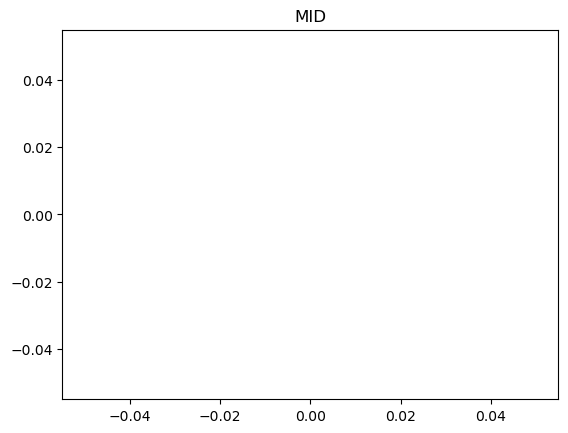

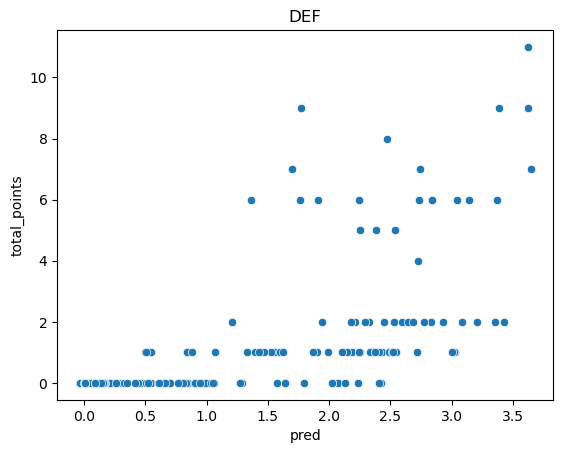

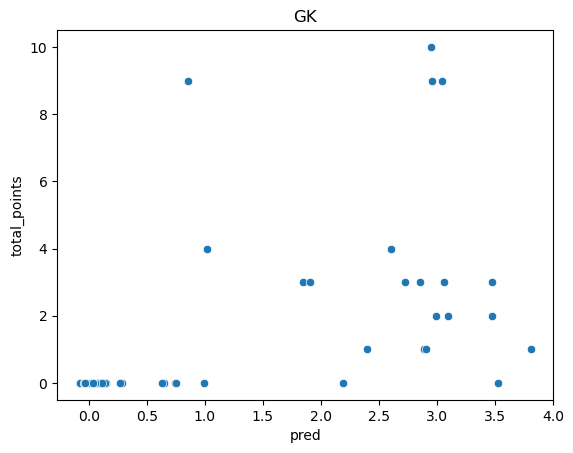

In [7]:
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    plt.figure()
    sns.scatterplot(data=pred_df.query('position==@pos'), y='total_points', x='pred').set(title=pos)

# Applying to this season's data

In [8]:
import requests, json

In [9]:
# import time
# def get_entry_gws_data(entry_id, num_gws, start_gw=1):
#     """ Retrieve the gw-by-gw data for a specific entry/team

#     Args:
#         entry_id (int) : ID of the team whose data is to be retrieved
#     """
#     base_url = "https://fantasy.premierleague.com/api/entry/"
#     gw_data = []
#     for i in range(start_gw, num_gws+1):
#         full_url = base_url + str(entry_id) + "/event/" + str(i) + "/picks/"
#         response = ''
#         while response == '':
#             try:
#                 response = requests.get(full_url)
#             except:
#                 time.sleep(5)
#         if response.status_code != 200:
#             raise Exception("Response was code " + str(response.status_code))
#         data = json.loads(response.text)
#         gw_data += [data]
#     return gw_data

In [10]:
# event_id = 1
# url = f'https://fantasy.premierleague.com/api/event/{event_id}/live/'

# response = requests.get(url)
# if response.status_code != 200:
#     raise Exception("Response was code " + str(response.status_code))
# gw1 = json.loads(response.text)

In [11]:

gw_dfs = []

for gw in range(38):
    event_id = gw + 1
    url = f'https://fantasy.premierleague.com/api/event/{event_id}/live/'
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Response was code " + str(response.status_code))
    gw1 = json.loads(response.text)

    # Ensure each 'stats' is a list
    elements = gw1['elements']
    for el in elements:
        if isinstance(el.get('stats'), dict):
            el['stats'] = [el['stats']]

    gw_df = pd.json_normalize(
        elements,
        record_path=['stats'],
        meta=['id', 'explain', 'modified']
    )

    gw_df['gw'] = event_id
    gw_dfs.append(gw_df)

gw_all = pd.concat(gw_dfs).reset_index(drop=True)

In [ ]:
# def make_ewma_features_df(gw_df, year, alpha):
#     # gw_df = get_dfs(year)
#     gw_df = add_goals(gw_df)
#     gw_df = clean_name_in_index(gw_df)

#     player_value_cols = ['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
#                       'influence', 'creativity', 'threat', 'ict_index', 'minutes', 'total_points']
#     merge_cols_players = ['full_name', 'gw', 'total_points', 'position','team','opponent_team']
#     ewma_gw_df_players = ewma(gw_df, 'full_name', player_value_cols, alpha, {'total_points': 'ewma_total_points'}, merge_cols_players)

#     gw_df_teams = get_teams_df(gw_df)
#     team_value_cols = ['team_goals']
#     merge_cols_teams = ['team', 'gw']
#     ewma_gw_df_teams = ewma(gw_df_teams, 'team', team_value_cols, alpha, {'team_goals': 'ewma_team_goals'}, merge_cols_teams)

#     ewma_merge_lag = merge_lag_player_ewma(ewma_gw_df_players, ewma_gw_df_teams, year)
#     return ewma_merge_lag

####### Need to figure out how to apply this to this year's df #######

In [13]:
league_url = 'https://draft.premierleague.com/api/league/19188/element-status'
r = requests.get(league_url).json()
ownership_df = pd.json_normalize(r['element_status'])